In [80]:
from sys import path
path.append('..')
path.append('../src')

import cv2
import numpy as np
import pickle as pkl
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.backend as K
from keras.models import load_model
from custom_metrics import eye_localization_accuracy, eye_localization_fvc

%matplotlib inline

In [81]:
dataset = pkl.load(open("../data/cropped_faces_eyes/dataset_dlib.pkl", "rb"))

In [87]:
x = np.array(dataset.images)
mrks = np.array(dataset.mrks)
y_eyes = np.array([mrk_file.right_eye.center().as_list() + mrk_file.left_eye.center().as_list() for mrk_file in mrks])
y_eyes = y_eyes / 160

print(x.shape, x.dtype)
print(y_eyes.shape, y_eyes.dtype)
print(len(mrks))

(4999, 160, 160, 3) float32
(4999, 4) float64
4999


In [83]:
model_clf = load_model("../models/unsupervised_supervised/model_2022_08_06-11_38_47.h5")

_, y_pred_reg = model_clf.predict(x / 255)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [88]:
scores = K.eval(eye_localization_fvc(y_eyes, y_pred_reg))

In [89]:
K.eval(eye_localization_accuracy(y_eyes, y_pred_reg))

0.4406881376275255

In [90]:
scores

array([0.37558764, 0.22444155, 0.10594683, ..., 0.1067208 , 0.15886794,
       0.05774506])

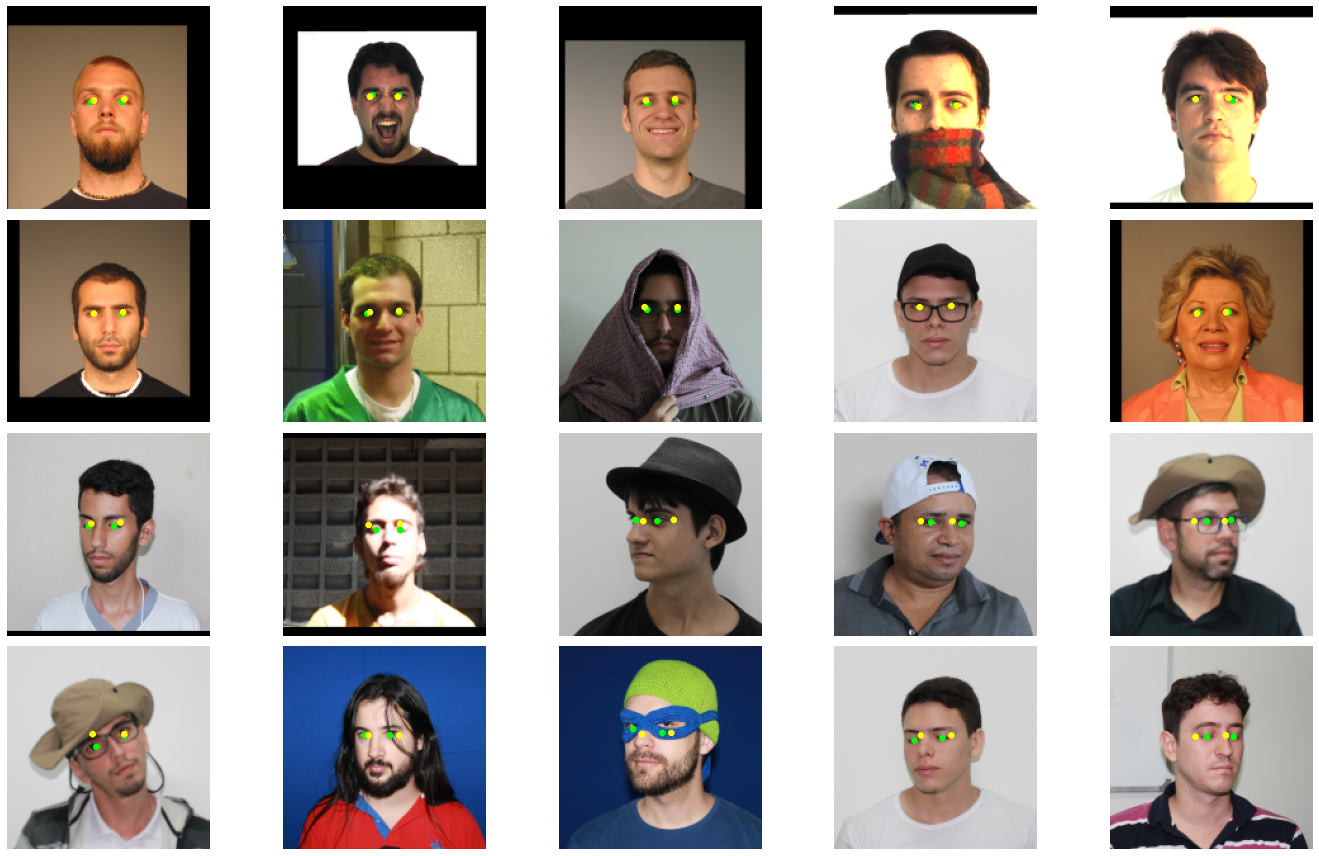

In [142]:
indexes = np.arange(x.shape[0])

top_5 = np.random.choice(indexes[scores <= 0.1], size=10, replace=False)
last_5 = np.random.choice(indexes[scores > 0.3], size=10, replace=False)
indexes = np.concatenate([top_5, last_5])


plt.figure(figsize=(20, 12))
for i, idx in enumerate(indexes, start=1):
    im = x[idx].astype(np.uint8)
    y_true = y_eyes[idx] * 160
    y_pred = y_pred_reg[idx] * 160
    
    eye_left = tuple(y_true[:2].astype(np.int))
    eye_right = tuple(y_true[2:].astype(np.int))
    cv2.circle(im, eye_left, radius=1, color=(0, 255, 0), thickness=2)
    cv2.circle(im, eye_right, radius=1, color=(0, 255, 0), thickness=2)
    
    eye_left = tuple(y_pred[:2].astype(np.int))
    eye_right = tuple(y_pred[2:].astype(np.int))
    cv2.circle(im, eye_left, radius=1, color=(0, 255, 255), thickness=2)
    cv2.circle(im, eye_right, radius=1, color=(0, 255, 255), thickness=2)
    
    plt.subplot(4, 5, i)
    plt.imshow(im[:,:,::-1])
    plt.axis("off")
plt.tight_layout()
plt.savefig("eyes.pdf", pad_inches=0)

In [ ]:
def image_batch(batch, y_true, y_pred=None, dict_labels=None, n_cols=10, figsize=(16,5)):
    plt.figure(figsize=figsize)
    
    y_pred = y_true if y_pred is None else y_pred
    n_rows = batch.shape[0] // n_cols + 1
    for img, true, pred, sub in zip(batch, y_true, y_pred, range(1, len(batch)+1)):
        plt.subplot(n_rows, n_cols, sub)
        plt.imshow(img.astype(np.uint8))
        
        true = true if dict_labels is None else dict_labels[true]
        pred = pred if dict_labels is None else dict_labels[pred]
        plt.title(f'T: {true} P: {pred}', color = 'green' if true == pred else 'red')
        plt.axis('off')
    plt.tight_layout()
